#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit 

#### Load Data

In [2]:
compressor_table = {
    "gz": "gzip",
    "bz2": "bzip2",
    "lzma": "lzma",
    "zst": "zstd",
    "paq8n": "paq8",
    "nncp": "nncp",
    "mfc": "MFCompress",
    "naf": "naf",
    "spr": "spring",
    "tar": "JARVIS3",
    "dsrc": "dsrc",
    "fqz": "fqzcomp",
    "qp": "quip"
}

def load_data(file_type):
    df = pd.DataFrame()
    for filename in os.listdir(f"output/{file_type}/info"):
        compressor = filename.split("_")[0]
        filesize = filename.split("_")[1].split(".")[0]

        tmp = pd.read_csv(f"output/{file_type}/info/{filename}")
        tmp["compressor"] = compressor
        tmp["filesize"] = filesize


        if os.path.exists(f"output/{file_type}/decompression_results/{filename}"):
            tmp2 = pd.read_csv(f"output/{file_type}/decompression_results/{filename}")
            tmp2.rename(columns={
                "task-clock": "dtask-clock",
                "cycles": "dcycles",
                "instructions": "dinstructions",
                "time-elapsed": "dtime-elapsed",
            }, inplace=True)
            tmp2["compressor"] = compressor
            tmp2["filesize"] = filesize
            tmp = pd.merge(tmp, tmp2, on=["compressor", "filesize"])
            df = pd.concat([df, tmp])
        else:
            df = pd.concat([df, tmp])


    for filename in os.listdir(f"output/{file_type}/compressed_files"):
        suffix = filename.split(".")[-1]
        if suffix == "txt":
            with open(f"output/{file_type}/compressed_files/{filename}", "r") as file:
                for line in file:
                    line = line.split(" ")
                    compressor_suffix = line[0].split(".")[-1]
                    compressor = compressor_table[compressor_suffix]
                    filesize = line[0].split(".")[0]
                    comp_size = int(line[1])
                    df.loc[(df["compressor"]==compressor) & (df["filesize"]==filesize), "compressed_size"] = comp_size
                break


        compressor = compressor_table[suffix]
        filesize = filename.split(".")[0]
        # print(filename, os.path.getsize(f"output/{file_type}/compressed_files/{filename}"))
        comp_size = os.path.getsize(f"output/{file_type}/compressed_files/{filename}")

        # Add compressed_size column to df
        df.loc[(df["compressor"]==compressor) & (df["filesize"]==filesize), "compressed_size"] = comp_size
    return df


In [4]:
def plot_stat(df: pd.DataFrame, decompression=False, log=True):
    titles = [
        "Time elapsed (s)",
        "Nº of instructions",
        "Nº of cycles",
    ]
    columns = [
        "time-elapsed",
        "instructions",
        "cycles",
    ]
    if decompression:
        columns = [
            "dtime-elapsed",
            "dinstructions",
            "dcycles",
        ]

    plot_layouts = [0,1,2]
    markers = [
        "o",
        "x",
        "s",
        "D",
        "P",
        "*",
    ]

    compressors = df["compressor"].unique()
    tmp = df.groupby(["compressor", "filesize"]).mean().reset_index()
    tmp = df.groupby(["compressor", "filesize"]).mean().reset_index().reindex(index=tmp.index[::-1])
    tmp["filesize"] = tmp["filesize"].apply(lambda x: int(x.split("Mb")[0]))
    tmp.sort_values(by="filesize", inplace=True)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for title, column, x in zip(titles, columns, plot_layouts):
        for i, compressor in enumerate(compressors):
            # check if column as values
            if tmp[tmp["compressor"] == compressor][column].isnull().all():
                continue

            ax[x].plot(
                tmp[tmp["compressor"] == compressor]["filesize"],
                tmp[tmp["compressor"] == compressor][column],
                label=compressor,
                marker=markers[i],
            )
        ax[x].set_xlabel("Filesize (MB)")
        ax[x].set_ylabel(title)
        ax[x].legend()
        if log:
            ax[x].set_yscale("log")
            ax[x].set_xscale("log")
        #ax[x].set_title(title)



In [3]:
def plot_compressed_size(df: pd.DataFrame, filesizes=[]):
    
    if not filesizes:
        filesizes =["1Mb", "10Mb", "100Mb", "1000Mb"]

    plot_layouts = [(0,0), (0,1), (1,0), (1,1)]

    # make plot larger


    fig, ax = plt.subplots(2, 2, figsize=(12, 12))

    for filesize, plot_layout in zip(filesizes, plot_layouts):
        # for compressor in compressors:
        #     comp_size = df[(df["compressor"]==compressor) & (df["filesize"]==filesize)]["compressed_size"].values[0]
        #     print(f"{compressor} - {filesize}: {comp_size} bytes")

        # sort bar plot by compressed size
        tmp = df.sort_values(by=["filesize", "compressed_size"])
        x, y = plot_layout

        ax[x, y].bar(
            tmp[tmp["filesize"]==filesize]["compressor"],
            tmp[tmp["filesize"]==filesize]["compressed_size"]
        )
        # add bar with original size
        # ax[x, y].axhline(
        #     y=1_000_000*int(filesize.split("Mb")[0]), 
        #     color="red", 
        #     linestyle="--", 
        #     label="Original size"
        # )

        # get minimum compressed size
        min_size = tmp[tmp["filesize"]==filesize]["compressed_size"].min()
        max_size = tmp[tmp["filesize"]==filesize]["compressed_size"].max()


        filesize1 = int(filesize.split("Mb")[0])*1_000_000

        # make scale smaller
        ax[x, y].set_ylim(min_size-filesize1*0.01, max_size+filesize1*0.01)


        ax[x, y].set_ylabel("Compressed size (bytes)")
        ax[x, y].set_xlabel("Compressor")
        ax[x, y].set_title(f"Compressed size for {filesize} files")
        # y axis in scientific notation
        ax[x, y].ticklabel_format(style='sci', axis='y', scilimits=(0,0))



    
    

In [5]:
def box_plot(df: pd.DataFrame, without_first=False):


    compressors = df["compressor"].unique()
    tmp = df.groupby(["compressor", "filesize"]).mean().reset_index()
    if without_first:
        tmp = tmp[tmp["filesize"]!="1Mb"]

    data = []
    for compresor in compressors:
        data.append(
            [
                int(fsize.split("Mb")[0])/(compsize/1_000_000) 
                for fsize, compsize in 
                    zip(tmp[tmp["compressor"]==compresor]["filesize"], 
                        tmp[tmp["compressor"]==compresor]["compressed_size"]
                    )
            ]
        )

    fig, ax = plt.subplots()
    ax.boxplot(data, labels=compressors)
    ax.set_ylabel("Compression ratio")
    ax.set_xlabel("Compressor")

## Random Text Files

In [39]:
df = load_data("random_text")
df.head()


,task-clock,cycles,instructions,time-elapsed,compressor,filesize,dtask-clock,dcycles,dinstructions,dtime-elapsed,compressed_size
0,211.86,818500889,1000166135,0.212468,lzma,1Mb,27.80,101534595.0,222982297.0,0.028406,773567.0
1,211.86,818500889,1000166135,0.212468,lzma,1Mb,27.45,103395802.0,227890055.0,0.027852,773567.0
2,211.86,818500889,1000166135,0.212468,lzma,1Mb,28.41,103041619.0,223329928.0,0.028989,773567.0
3,211.86,818500889,1000166135,0.212468,lzma,1Mb,27.80,100412518.0,222765532.0,0.028896,773567.0
4,211.86,818500889,1000166135,0.212468,lzma,1Mb,28.03,103247883.0,225821479.0,0.028440,773567.0


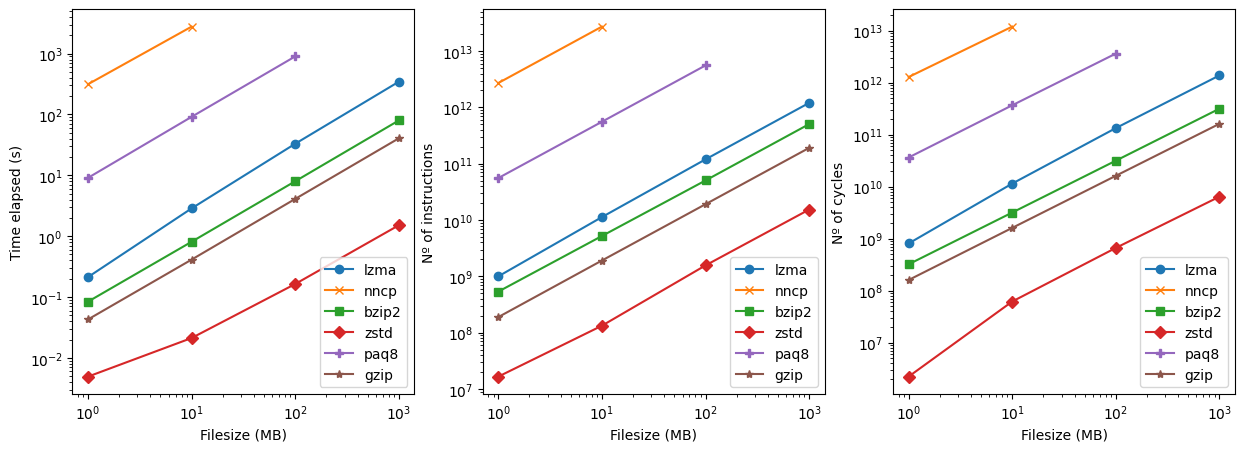

In [41]:
plot_stat(df)

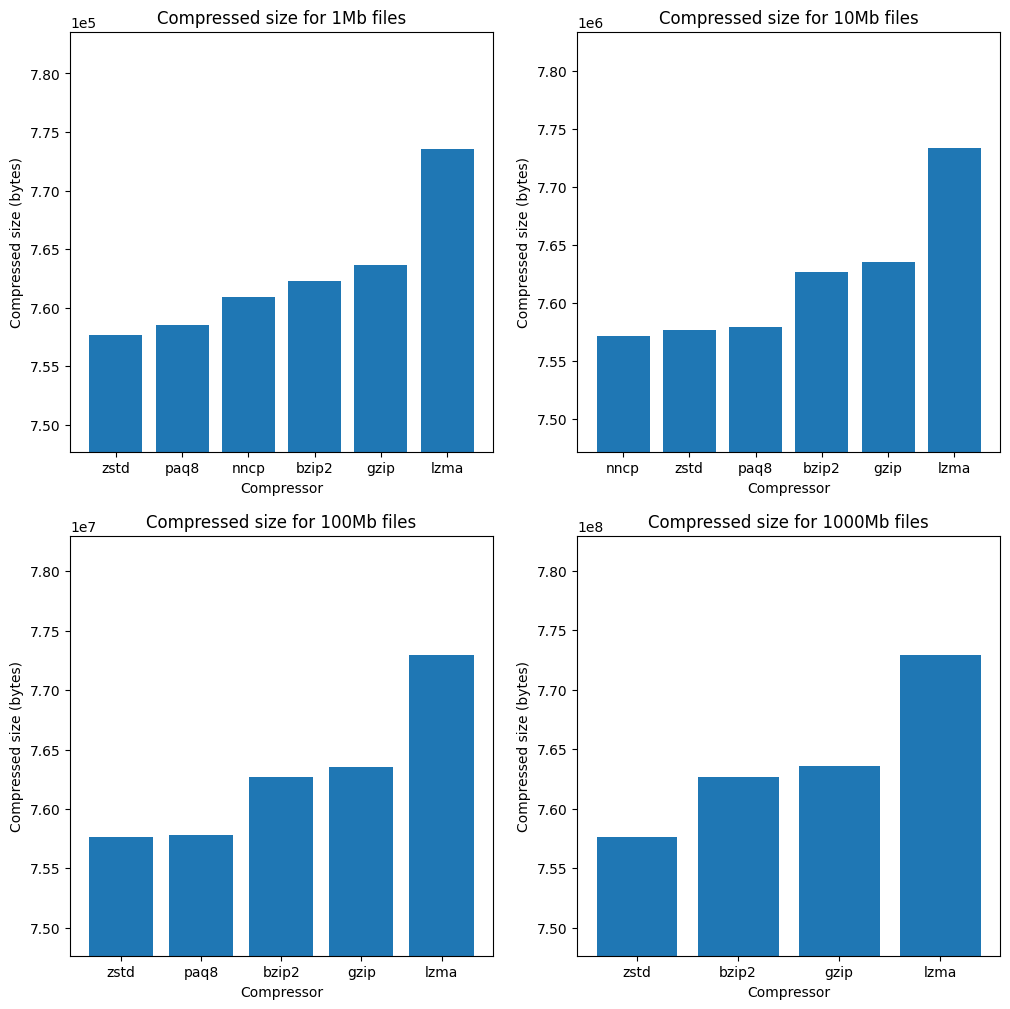

In [42]:
plot_compressed_size(df)

/tmp/ipykernel_3493/1818747930.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=compressors)


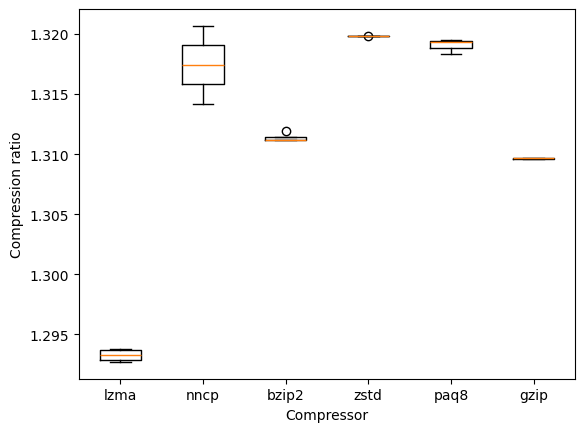

In [43]:
box_plot(df)

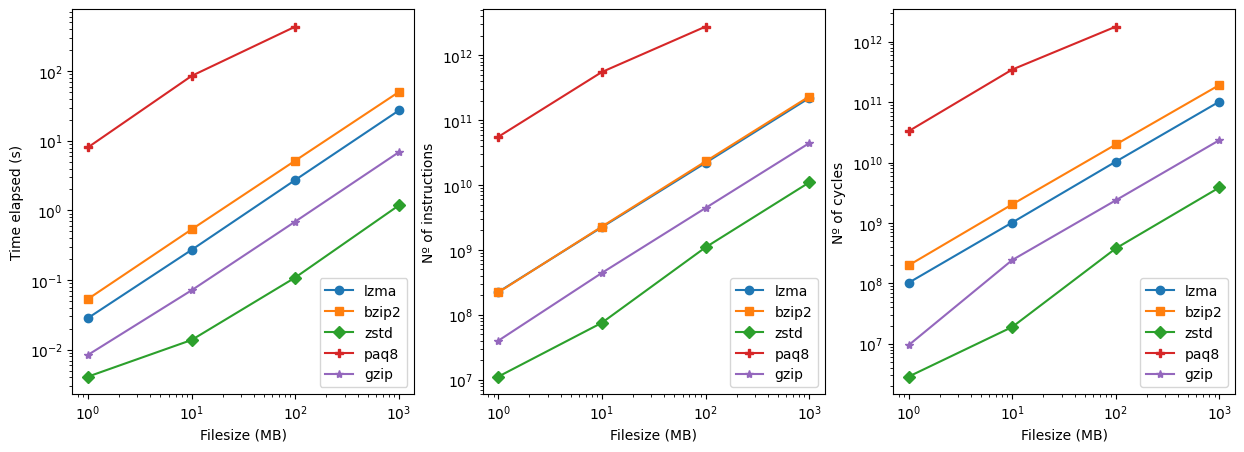

In [44]:
plot_stat(df, decompression=True)

## Text files

In [45]:
df = load_data("text")
df.head()

,task-clock,cycles,instructions,time-elapsed,compressor,filesize,dtask-clock,dcycles,dinstructions,dtime-elapsed,compressed_size
0,381.75,1520910863,1966411607,0.383755,lzma,1Mb,2.10,4450556.0,6345100.0,0.002695,269294.0
1,381.75,1520910863,1966411607,0.383755,lzma,1Mb,1.83,2711916.0,6345102.0,0.002192,269294.0
2,381.75,1520910863,1966411607,0.383755,lzma,1Mb,1.77,4174202.0,6345098.0,0.002121,269294.0
3,381.75,1520910863,1966411607,0.383755,lzma,1Mb,2.09,2339900.0,6345104.0,0.002453,269294.0
4,381.75,1520910863,1966411607,0.383755,lzma,1Mb,2.11,4268685.0,6345121.0,0.002475,269294.0


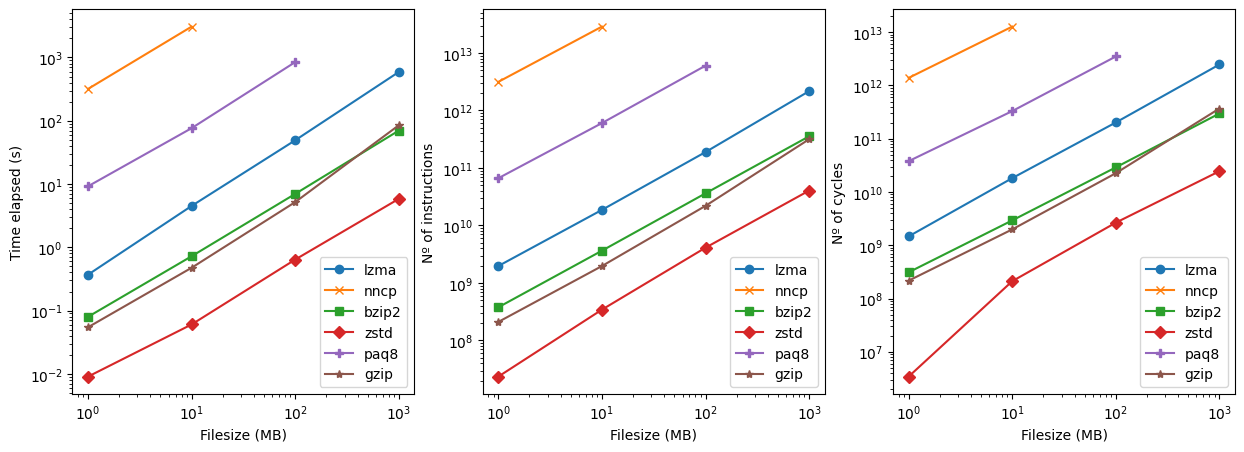

In [46]:
plot_stat(df)

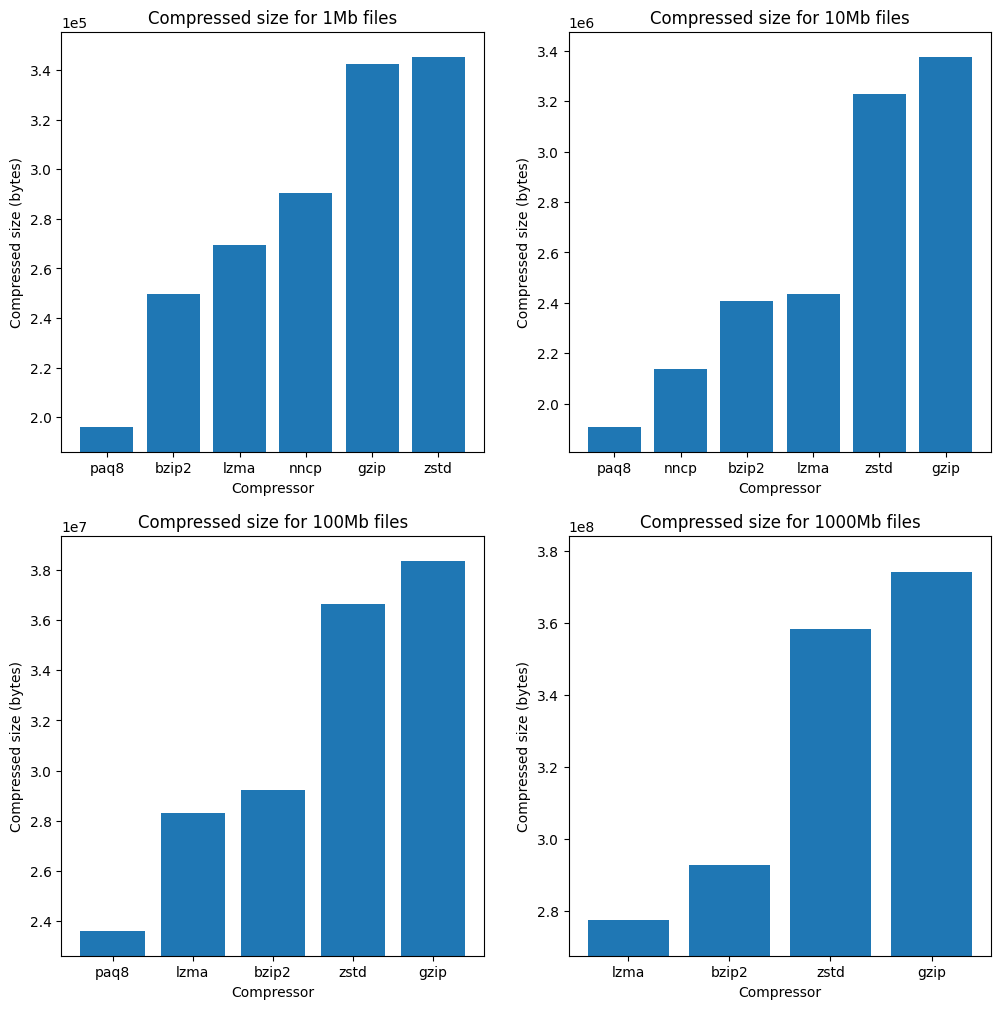

In [47]:
plot_compressed_size(df)

/tmp/ipykernel_3493/1818747930.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=compressors)


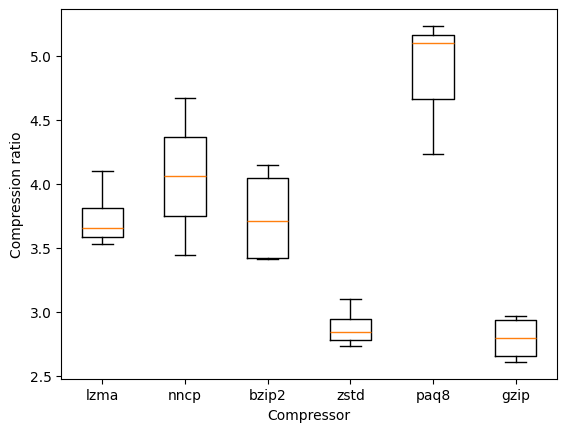

In [48]:
box_plot(df)

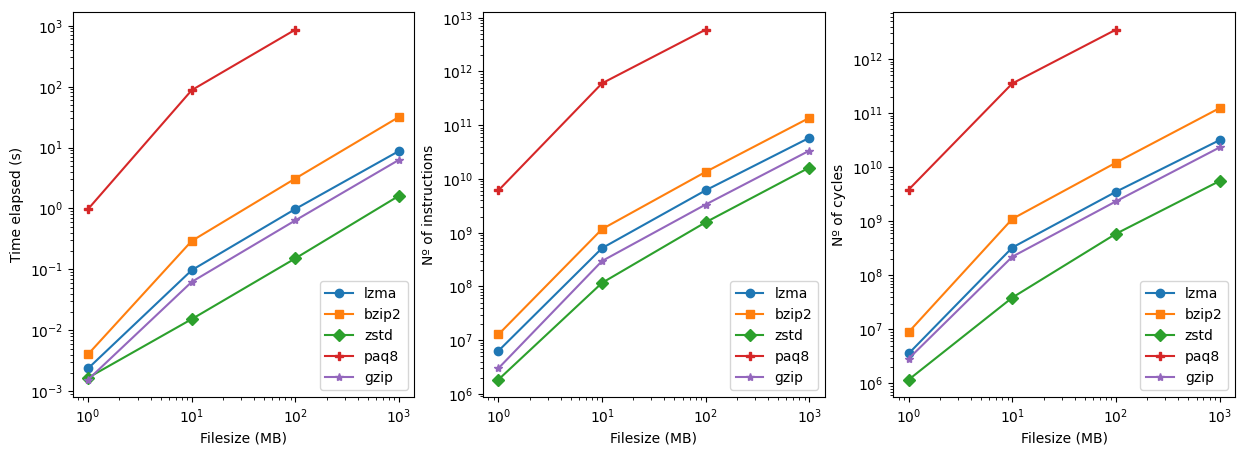

In [49]:
plot_stat(df, decompression=True)

Calculate decompression time polynomial

In [50]:
algorithms = df["compressor"].unique()
df["filesize_int"] = df.apply(lambda x: int(x["filesize"].split("Mb")[0]), axis=1)

for alg in algorithms:

    tmp = df[df["compressor"] == alg][["filesize","time-elapsed","filesize_int"]].groupby("filesize").mean().reset_index()
    a,b = np.polyfit(tmp["filesize_int"], tmp["time-elapsed"], 1)
    print(alg, a, b)

    

lzma 0.5939386874725272 -3.7569765646943893
nncp 306.1340189846223 12.036864973178076
bzip2 0.06995719528937644 0.00861547317570249
zstd 0.005820163992502575 0.019990516482410323
paq8 8.486976394850448 -3.6794410439332172
gzip 0.0859315689382117 -1.2041857752382892


Calculate decompression time polynomial

In [14]:
algorithms = df["compressor"].unique()
df["filesize_int"] = df.apply(lambda x: int(x["filesize"].split("Mb")[0]), axis=1)

for alg in algorithms:
    tmp = df[df["compressor"] == alg][["filesize","dtime-elapsed","filesize_int"]].groupby("filesize").mean().reset_index()
    a,b = np.polyfit(tmp["filesize_int"], tmp["dtime-elapsed"], 1)
    print(alg, a, b)

lzma 0.008731198729312004 0.03522073873359222
nncp nan nan
bzip2 0.03173071586466852 -0.03967835046167831
zstd 0.001617501037717417 -0.0033029067260122898
paq8 8.614794770760657 -3.455378419344333
gzip 0.006272655440768861 0.0017238886764497504


Calculate compression ratio

In [51]:
algorithms = df["compressor"].unique()

for alg in algorithms:

    tmp = df[df["compressor"] == alg][["filesize","compressed_size","filesize_int"]].groupby("filesize").mean().reset_index()
    tmp["comp_ratio"] = tmp["filesize_int"]/(tmp["compressed_size"]/1_000_000)
    
    #print(alg, tmp)
    print(alg, tmp["comp_ratio"].mean())

lzma 3.737348138206464
nncp 4.058016224384912
bzip2 3.747588716830368
zstd 2.878278975146356
paq8 4.855872277018734
gzip 2.7910018846339857


## FASTA

In [52]:
df = load_data("genome/fasta")
df.head()

,task-clock,cycles,instructions,time-elapsed,compressor,filesize,dtask-clock,dcycles,dinstructions,dtime-elapsed,compressed_size
0,100527.93,419808061161,341733257613,100.80365,gzip,1200Mb,6324.43,19717175810,25369240205,7.559958,222706276.0
1,100527.93,419808061161,341733257613,100.80365,gzip,1200Mb,5732.62,20091350780,25298720443,5.816429,222706276.0
2,100527.93,419808061161,341733257613,100.80365,gzip,1200Mb,5725.00,20070369959,25353231604,5.753883,222706276.0
3,100527.93,419808061161,341733257613,100.80365,gzip,1200Mb,5829.70,20463740438,25346100433,5.847727,222706276.0
4,100527.93,419808061161,341733257613,100.80365,gzip,1200Mb,6090.76,21099009836,25346112272,6.094063,222706276.0


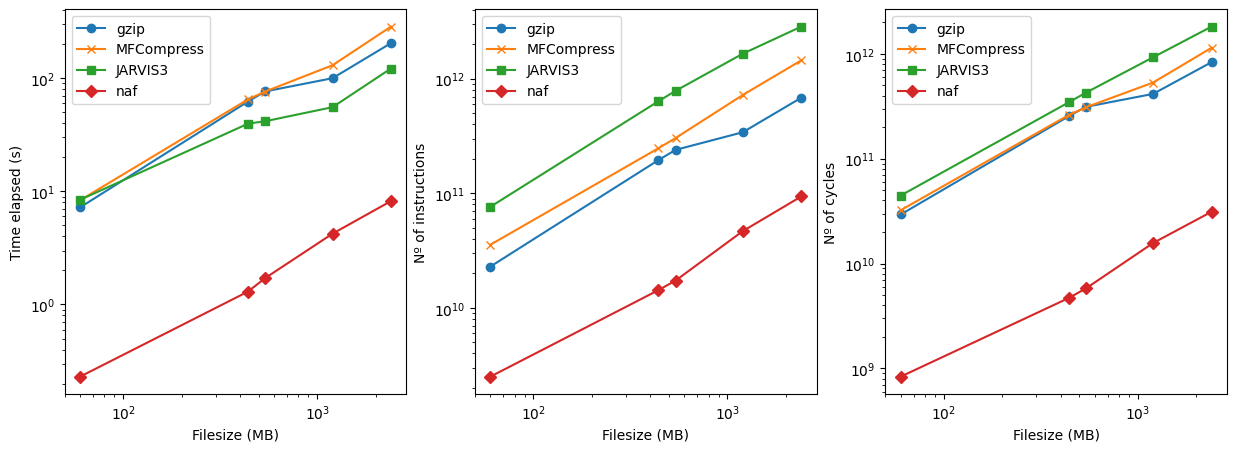

In [53]:
# remove lines with filesize = 3000Mb
df = df[df["filesize"]!="3000Mb"]

plot_stat(df, log=True)

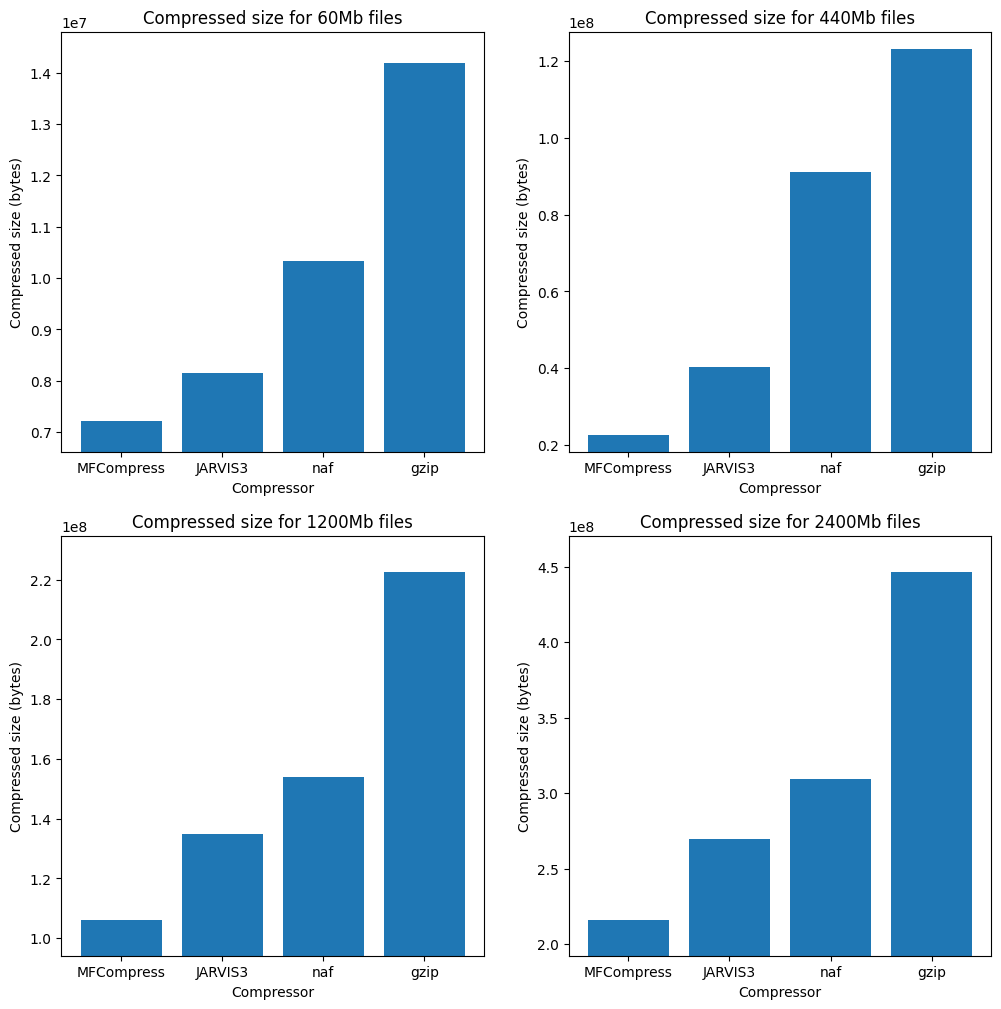

In [54]:
plot_compressed_size(df, filesizes=["60Mb", "440Mb", "1200Mb", "2400Mb"])

/tmp/ipykernel_3493/1818747930.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=compressors)


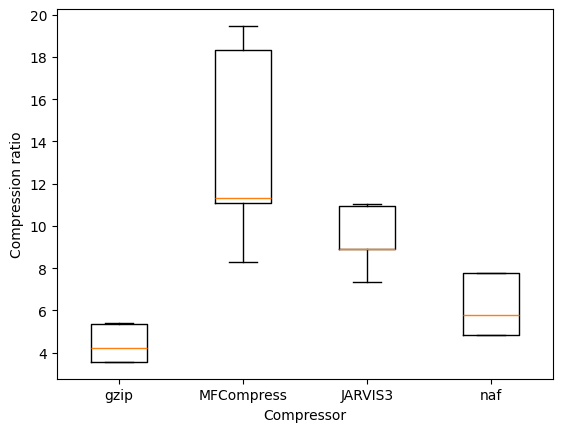

In [55]:
box_plot(df)

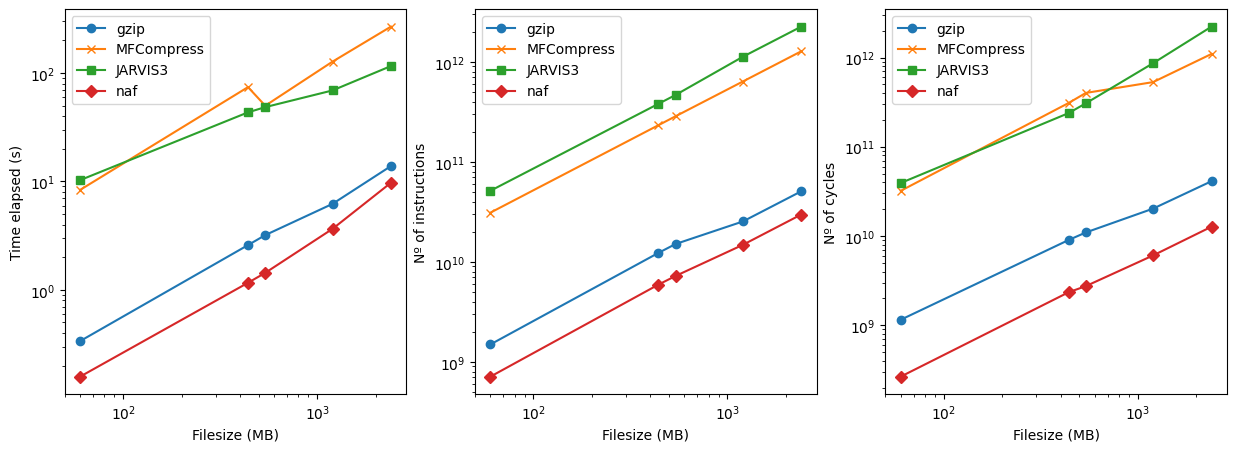

In [56]:
plot_stat(df, decompression=True)

Calculate compression time polynomial

In [57]:
algorithms = df["compressor"].unique()
df["filesize_int"] = df.apply(lambda x: int(x["filesize"].split("Mb")[0]), axis=1)

for alg in algorithms:

    tmp = df[df["compressor"] == alg][["filesize","time-elapsed","filesize_int"]].groupby("filesize").mean().reset_index()
    a,b = np.polyfit(tmp["filesize_int"], tmp["time-elapsed"], 1)
    print(alg, a, b)

gzip 0.07723361130396895 18.309567930956838
MFCompress 0.11452452417681527 6.81504708499546
JARVIS3 0.04480069022923026 11.824026571914338
naf 0.003463987760975265 -0.0807849407850438


Calculate decompression time polynomial

In [58]:
algorithms = df["compressor"].unique()
df["filesize_int"] = df.apply(lambda x: int(x["filesize"].split("Mb")[0]), axis=1)

for alg in algorithms:

    tmp = df[df["compressor"] == alg][["filesize","dtime-elapsed","filesize_int"]].groupby("filesize").mean().reset_index()
    a,b = np.polyfit(tmp["filesize_int"], tmp["dtime-elapsed"], 1)
    print(alg, a, b)

gzip 0.005710355896576588 -0.0564327767730708
MFCompress 0.1085070190599624 5.05659088651492
JARVIS3 0.04164054354312043 18.88983950470426
naf 0.004156843201085991 -0.6287881686966884


Calculate compression ratio

In [59]:
algorithms = df["compressor"].unique()

for alg in algorithms:

    tmp = df[df["compressor"] == alg][["filesize","compressed_size","filesize_int"]].groupby("filesize").mean().reset_index()
    tmp["comp_ratio"] = tmp["filesize_int"]/(tmp["compressed_size"]/1_000_000)
    
    # print(alg, tmp)
    print(alg, tmp["comp_ratio"].mean())

gzip 4.423788726989497
MFCompress 13.70339431591971
JARVIS3 9.435300799533561
naf 6.204930663466914


## FASTQ

In [69]:
df = load_data("genome/fastq")
df.head()

,task-clock,cycles,instructions,time-elapsed,compressor,filesize,dtask-clock,dcycles,dinstructions,dtime-elapsed,compressed_size
0,55550.74,189515803012,418798801132,40.86526,fqzcomp,4800Mb,62175.76,231648166488,385460110903,41.055880,240959677.0
1,55550.74,189515803012,418798801132,40.86526,fqzcomp,4800Mb,62525.42,231989213900,386248461509,41.128381,240959677.0
2,55550.74,189515803012,418798801132,40.86526,fqzcomp,4800Mb,62516.52,230893154907,386022504040,41.168223,240959677.0
3,55550.74,189515803012,418798801132,40.86526,fqzcomp,4800Mb,62227.69,231023984847,384490835437,41.296740,240959677.0
4,55550.74,189515803012,418798801132,40.86526,fqzcomp,4800Mb,61614.28,230315349711,385312040201,40.935208,240959677.0


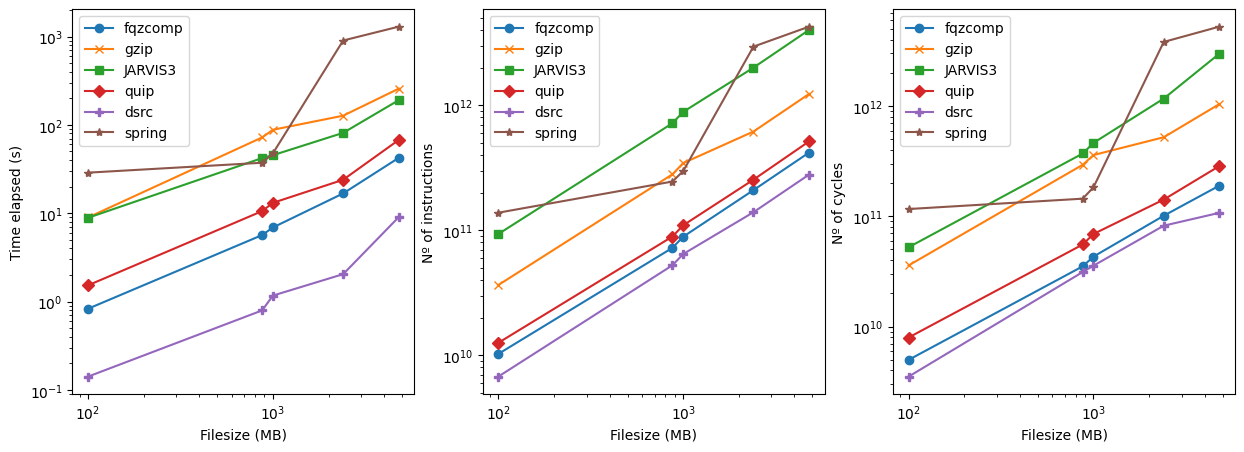

In [64]:
plot_stat(df, log=True)

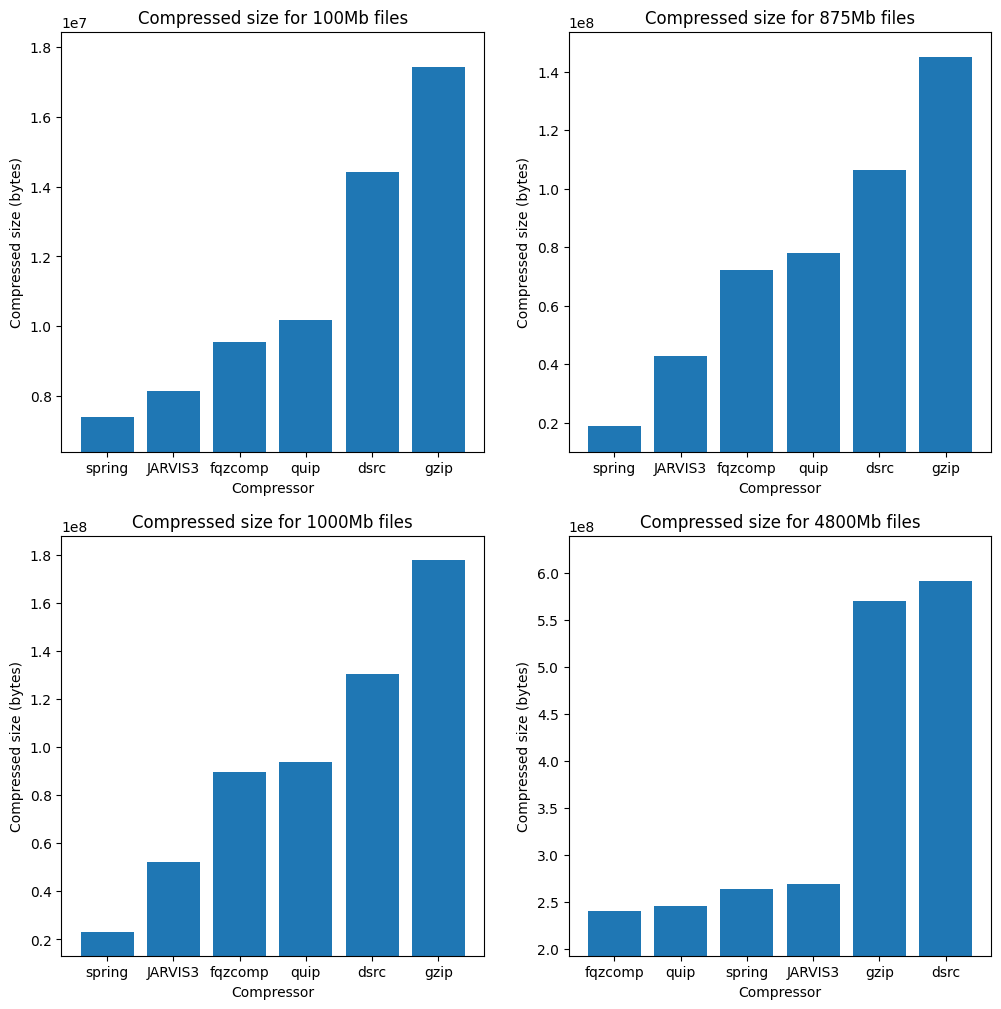

In [65]:
plot_compressed_size(df, filesizes=["100Mb", "875Mb", "1000Mb", "4800Mb"])

/tmp/ipykernel_3493/1818747930.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=compressors)


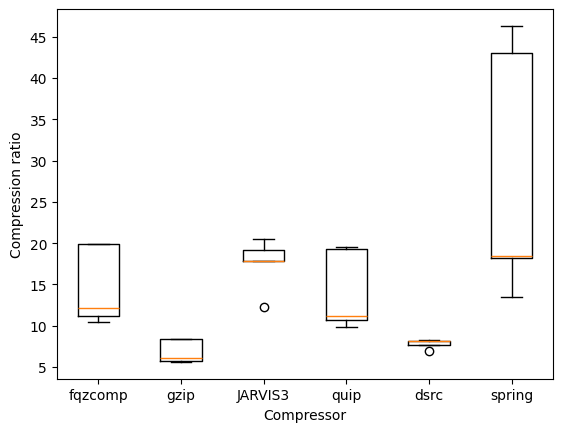

In [66]:
box_plot(df)

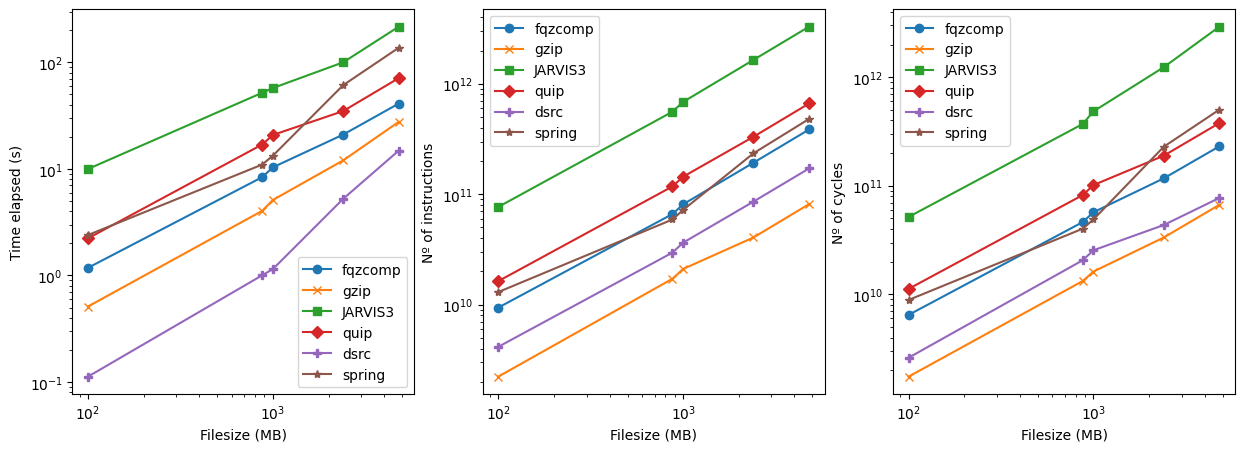

In [67]:
plot_stat(df, decompression=True, log=True)

Calculate compression time polynomial

In [71]:
algorithms = df["compressor"].unique()
df["filesize_int"] = df.apply(lambda x: int(x["filesize"].split("Mb")[0]), axis=1)

for alg in algorithms:

    tmp = df[df["compressor"] == alg][["filesize","time-elapsed","filesize_int"]].groupby("filesize").mean().reset_index()
    a,b = np.polyfit(tmp["filesize_int"], tmp["time-elapsed"], 1)
    print(alg, a, b)

fqzcomp 0.0089215238643304 -1.8557768057462742
gzip 0.04925396252853954 20.344755700249976
JARVIS3 0.03768560676248917 4.530388258432371
quip 0.0138538440401515 -2.061452548857993
dsrc 0.0018967919879248035 -0.8362393212486807
spring 0.3072409901425346 -101.89389893323083


Calculate decompression time polynomial

In [72]:
algorithms = df["compressor"].unique()
df["filesize_int"] = df.apply(lambda x: int(x["filesize"].split("Mb")[0]), axis=1)

for alg in algorithms:

    tmp = df[df["compressor"] == alg][["filesize","dtime-elapsed","filesize_int"]].groupby("filesize").mean().reset_index()
    a,b = np.polyfit(tmp["filesize_int"], tmp["dtime-elapsed"], 1)
    print(alg, a, b)

fqzcomp 0.008373442220949304 1.0408669009980231
gzip 0.0058178593509502 -0.7953400294564735
JARVIS3 0.04250750461229266 9.247332431842974
quip 0.014082471706811843 3.4011017376174224
dsrc 0.0032755308540195057 -1.5306944106457923
spring 0.03029848142344252 -10.533786819837012


Calculate compression ratio

In [73]:
algorithms = df["compressor"].unique()
df["filesize_int"] = df.apply(lambda x: int(x["filesize"].split("Mb")[0]), axis=1)

for alg in algorithms:

    tmp = df[df["compressor"] == alg][["filesize","compressed_size","filesize_int"]].groupby("filesize").mean().reset_index()
    tmp["comp_ratio"] = tmp["filesize_int"]/(tmp["compressed_size"]/1_000_000)
    
    # print(alg, tmp)
    print(alg, tmp["comp_ratio"].mean())

fqzcomp 14.720147946072032
gzip 6.85275822164251
JARVIS3 17.512562624586838
quip 14.088330669583907
dsrc 7.80912061351529
spring 27.89895872654991


### Energy Model

Model parameters for 3 datacenter types

In [22]:
import math
import time
import matplotlib.pyplot as plt

server_bandwidth = [50, 160, 300]
p_server = [118, 246, 365]
server_switch_bandwidth = [2500, 12500, 25000]
p_server_switch = [67, 500, 4500]
disk_bandwidth = [160, 200, 500]
p_disk_active = [5.90, 3.30, 1.45]
disk_size = [2_000_000, 500_000, 1_000_000]
pue_server = [2, 1.79, 1.13]
compression_rate = 2.79
compression_time_cost = 0.0856
decompression_time_cost = 0.00627
complexity_factor = [100, 100, 100]
#complexity_factor = [5, 5, 5]
upload_rate = 6.25
download_rate = 12.5
retention_time = 8736
#retention_time = 168
t_on = 24
t_use = 6
p_cpe = 8
n_cpe = 1
p_an = 2
n_an = 1
pue_an = 2
en_power_per_gb = 52
avg_user_power = 50
p_disk_idle = [4.25, 1.90, 1.30]



Energy model formulas

In [ ]:

def server_write_normal(d_in, index):
    return ((complexity_factor[index]*d_in/server_bandwidth[index])*(p_server[index]) + (d_in/server_switch_bandwidth[index])*p_server_switch[index] + (d_in/disk_bandwidth[index])*p_disk_active[index]*math.ceil(d_in/disk_size[index]))/3600*pue_server[index]

def server_write_comp(d_in, index, compression_rate, compression_time_cost):
    return ((complexity_factor[index]*d_in/server_bandwidth[index] + d_in*compression_time_cost)*(p_server[index]) + ((d_in/compression_rate)/server_switch_bandwidth[index])*p_server_switch[index] + ((d_in/compression_rate)/disk_bandwidth[index])*p_disk_active[index]*math.ceil((d_in/compression_rate)/disk_size[index]))/3600*pue_server[index]

def cpe_upload(d_in, index=None):
    return (d_in/upload_rate)/3600*(t_on/t_use)*(p_cpe/n_cpe)

def an_upload(d_in, index=None):
    return (d_in/upload_rate)/3600*(p_an/n_an)*pue_an

def en_upload(d_in, index=None):
    return d_in/1000*en_power_per_gb

def user_side_upload(d_in, index=None):
    return (d_in/upload_rate)/3600*avg_user_power

def storage_normal(d_in, index):
    return pue_server[index]*math.ceil((d_in)/disk_size[index])*p_disk_idle[index]*retention_time

def storage_comp(d_in, index, compression_rate):
    return pue_server[index]*math.ceil(((d_in)/compression_rate)/disk_size[index])*p_disk_idle[index]*retention_time

def server_read_normal(d_in, index):
    return pue_server[index]*(d_in)*(p_server[index]/server_bandwidth[index] + p_server_switch[index]/server_switch_bandwidth[index])/3600

def server_read_comp(d_in, index, compression_rate):
    return pue_server[index]*(d_in/compression_rate)*(p_server[index]/server_bandwidth[index] + p_server_switch[index]/server_switch_bandwidth[index])/3600

def cpe_download_normal(d_in, index=None):
    return (d_in/download_rate)/3600*(t_on/t_use)*(p_cpe/n_cpe)

def cpe_download_comp(d_in, index=None, compression_rate=2.79):
    return (d_in/compression_rate/download_rate)/3600*(t_on/t_use)*(p_cpe/n_cpe)

def an_download_normal(d_in, index=None):
    return (d_in/download_rate)/3600*(p_an/n_an)*pue_an

def an_download_comp(d_in, index=None, compression_rate=2.79):
    return (d_in/compression_rate/download_rate)/3600*(p_an/n_an)*pue_an

def en_download_normal(d_in, index=None):
    return d_in/1000*en_power_per_gb

def en_download_comp(d_in, index=None, compression_rate=2.79):
    return (d_in/compression_rate)/1000*en_power_per_gb

def user_side_download_normal(d_in, index=None):
    return (d_in/download_rate)/3600*avg_user_power

def user_side_download_comp(d_in, index=None, compression_rate=2.79, decompression_time_cost=0.00627):
    return avg_user_power*(((d_in/compression_rate)/download_rate) + decompression_time_cost*d_in)/3600




In [43]:
data1 = []
data2 = []
data3 = []
data4 = []
data5 = []
data6 = []
data7 = []
data8 = []
data9 = []
data10 = []
data11 = []
data12 = []

max_size = 10_000_001
step = 100_000
#max_size = 1_000_01
#step = 1_000

for index, data in enumerate([data1, data2, data3]):

    for d_in in range(0, max_size, step):
        data.append(
            [
                server_write_normal(d_in, index)/1e3,
                cpe_upload(d_in, index)/1e3,
                an_upload(d_in, index)/1e3,
                en_upload(d_in, index)/1e3,
                user_side_upload(d_in, index)/1e3,
                storage_normal(d_in, index)/1e3,
                server_read_normal(d_in, index)/1e3,
                cpe_download_normal(d_in, index)/1e3,
                an_download_normal(d_in, index)/1e3,
                en_download_normal(d_in, index)/1e3,
                user_side_download_normal(d_in, index)/1e3,
            ]
        )
for index, data in enumerate([data4, data5, data6]):
    comp_rate = 2.79
    comp_t_cost = 8.59e-2
    decomp_t_cost = 6.27e-3
    for d_in in range(0, max_size, step):
        data.append(
            [
                server_write_comp(d_in, index, compression_rate=comp_rate, compression_time_cost=comp_t_cost)/1e3,
                cpe_upload(d_in, index)/1e3,
                an_upload(d_in, index)/1e3,
                en_upload(d_in, index)/1e3,
                user_side_upload(d_in, index)/1e3,
                storage_comp(d_in, index, compression_rate=comp_rate)/1e3,
                server_read_comp(d_in, index, compression_rate=comp_rate)/1e3,
                cpe_download_comp(d_in, index, compression_rate=comp_rate)/1e3,
                an_download_comp(d_in, index, compression_rate=comp_rate)/1e3,
                en_download_comp(d_in, index, compression_rate=comp_rate)/1e3,
                user_side_download_comp(d_in, index, compression_rate=comp_rate, decompression_time_cost=decomp_t_cost)/1e3,
            ]
        )

for index, data in enumerate([data7, data8, data9]):
    comp_rate = 2.89
    comp_t_cost = 5.82e-3
    decomp_t_cost = 1.62e-3
    for d_in in range(0, max_size, step):
        data.append(
            [
                server_write_comp(d_in, index, compression_rate=comp_rate, compression_time_cost=comp_t_cost)/1e3,
                cpe_upload(d_in, index)/1e3,
                an_upload(d_in, index)/1e3,
                en_upload(d_in, index)/1e3,
                user_side_upload(d_in, index)/1e3,
                storage_comp(d_in, index, compression_rate=comp_rate)/1e3,
                server_read_comp(d_in, index, compression_rate=comp_rate)/1e3,
                cpe_download_comp(d_in, index, compression_rate=comp_rate)/1e3,
                an_download_comp(d_in, index, compression_rate=comp_rate)/1e3,
                en_download_comp(d_in, index, compression_rate=comp_rate)/1e3,
                user_side_download_comp(d_in, index, compression_rate=comp_rate, decompression_time_cost=decomp_t_cost)/1e3,
            ]
        )

for index, data in enumerate([data10, data11, data12]):
    comp_rate = 14.7
    comp_t_cost = 8.92e-3
    decomp_t_cost = 8.37e-3
    for d_in in range(0, max_size, step):
        data.append(
            [
                server_write_comp(d_in, index, compression_rate=comp_rate, compression_time_cost=comp_t_cost)/1e3,
                cpe_upload(d_in, index)/1e3,
                an_upload(d_in, index)/1e3,
                en_upload(d_in, index)/1e3,
                user_side_upload(d_in, index)/1e3,
                storage_comp(d_in, index, compression_rate=comp_rate)/1e3,
                server_read_comp(d_in, index, compression_rate=comp_rate)/1e3,
                cpe_download_comp(d_in, index, compression_rate=comp_rate)/1e3,
                an_download_comp(d_in, index, compression_rate=comp_rate)/1e3,
                en_download_comp(d_in, index, compression_rate=comp_rate)/1e3,
                user_side_download_comp(d_in, index, compression_rate=comp_rate, decompression_time_cost=decomp_t_cost)/1e3,
            ]
        )



Data plot

Text(0, 0.5, 'Power (kWh)')

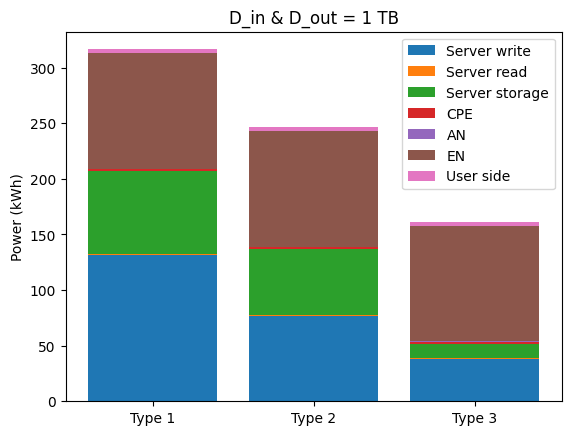

In [26]:
server_write = [
    data1[10][0],
    data2[10][0],
    data3[10][0]
]

cpe = [
    data1[10][1] + data1[10][7],
    data2[10][1] + data2[10][7],
    data3[10][1] + data3[10][7]
]
an = [
    data1[10][2] + data1[10][8],
    data2[10][2] + data2[10][8],
    data3[10][2] + data3[10][8]
]
en = [
    data1[10][3] + data1[10][9],
    data2[10][3] + data2[10][9],
    data3[10][3] + data3[10][9]
]
userside = [
    data1[10][4] + data1[10][10],
    data2[10][4] + data2[10][10],
    data3[10][4] + data3[10][10]
]
server_storage = [
    data1[10][5],
    data2[10][5],
    data3[10][5]
]
server_read = [
    data1[10][6],
    data2[10][6],
    data3[10][6]
]

d_in = [i for i in range(0, max_size, step)]

x = ["Type 1", "Type 2", "Type 3"]
fig, ax = plt.subplots()
ax.bar(x, server_write)
ax.bar(x, server_read, bottom=server_write)
ax.bar(x, server_storage, bottom=[sum(x) for x in zip(server_write, server_read)])
ax.bar(x, cpe, bottom=[sum(x) for x in zip(server_write, server_read, server_storage)])
ax.bar(x, an, bottom=[sum(x) for x in zip(server_write, server_read, server_storage, cpe)])
ax.bar(x, en, bottom=[sum(x) for x in zip(server_write, server_read, server_storage, cpe, an)])
ax.bar(x, userside, bottom=[sum(x) for x in zip(server_write, server_read, server_storage, cpe, an, en)])

ax.legend(["Server write", "Server read", "Server storage", "CPE", "AN", "EN", "User side"])
ax.set_title(f"D_in & D_out = 1 TB")
ax.set_ylabel("Power (kWh)")

In [14]:
print(d_in[10])
for el1, el2, el3 in zip(server_write, server_read, server_storage):
    print(sum([el1/1e3, el2/1e3, el3/1e3]))

1000000
0.2067284861111111
0.13669085394444444
0.05151880724074073


In [82]:
data1 = []
data2 = []
data3 = []
data4 = []
data5 = []
data6 = []

max_size = 100_000
step = 1_000

for index, data in enumerate([data1, data2, data3]):

    for d_in in range(0, max_size, step):
        data.append(
            [
                server_write_normal(d_in, index),
                #server_write_comp(d_in, index),
                cpe_upload(d_in, index),
                an_upload(d_in, index),
                en_upload(d_in, index),
                user_side_upload(d_in, index),
                storage_normal(d_in, index),
                #storage_comp(d_in, index),
                server_read_normal(d_in*2, index),
                #server_read_comp(d_in, index),
                cpe_download_normal(d_in*2, index),
                #cpe_download_comp(d_in, index),
                an_download_normal(d_in*2, index),
                #an_download_comp(d_in, index),
                en_download_normal(d_in*2, index),
                #en_download_comp(d_in, index),
                user_side_download_normal(d_in*2, index),
                #user_side_download_comp(d_in, index),
            ]
        )


1000000


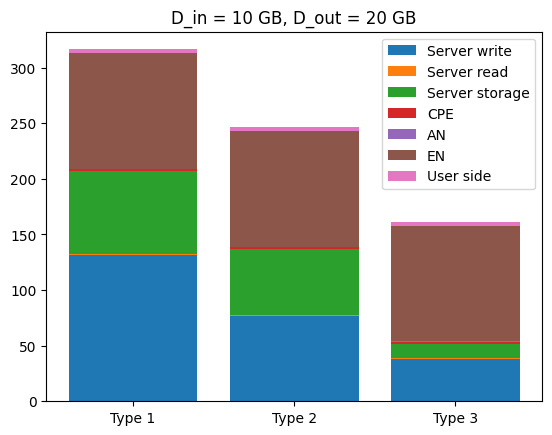

In [16]:
server_write = [
    data1[10][0],
    data2[10][0],
    data3[10][0]
]

cpe = [
    data1[10][1] + data1[10][7],
    data2[10][1] + data2[10][7],
    data3[10][1] + data3[10][7]
]
an = [
    data1[10][2] + data1[10][8],
    data2[10][2] + data2[10][8],
    data3[10][2] + data3[10][8]
]
en = [
    data1[10][3] + data1[10][9],
    data2[10][3] + data2[10][9],
    data3[10][3] + data3[10][9]
]
userside = [
    data1[10][4] + data1[10][10],
    data2[10][4] + data2[10][10],
    data3[10][4] + data3[10][10]
]
server_storage = [
    data1[10][5],
    data2[10][5],
    data3[10][5]
]
server_read = [
    data1[10][6],
    data2[10][6],
    data3[10][6]
]

d_in = [i for i in range(0, max_size, step)]

x = ["Type 1", "Type 2", "Type 3"]
fig, ax = plt.subplots()
ax.bar(x, server_write)
ax.bar(x, server_read, bottom=server_write)
ax.bar(x, server_storage, bottom=[sum(x) for x in zip(server_write, server_read)])
ax.bar(x, cpe, bottom=[sum(x) for x in zip(server_write, server_read, server_storage)])
ax.bar(x, an, bottom=[sum(x) for x in zip(server_write, server_read, server_storage, cpe)])
ax.bar(x, en, bottom=[sum(x) for x in zip(server_write, server_read, server_storage, cpe, an)])
ax.bar(x, userside, bottom=[sum(x) for x in zip(server_write, server_read, server_storage, cpe, an, en)])

ax.legend(["Server write", "Server read", "Server storage", "CPE", "AN", "EN", "User side"])
ax.set_title(f"D_in = 10 GB, D_out = 20 GB")
print(d_in[10])

In [20]:
en

[10400.0, 10400.0, 10400.0]

In [15]:
d_in[10]

1000000

In [14]:
en_power_per_gb*d_in[10]/1000

52000.0

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Type 1'),
  Text(1, 0, 'T1 gzip'),
  Text(2, 0, 'T1 zstdard'),
  Text(3, 0, 'T1 JARVIS3'),
  Text(4, 0, 'Type 2 '),
  Text(5, 0, 'T2 gzip'),
  Text(6, 0, 'T2 zstandard'),
  Text(7, 0, 'T2 JARVIS3'),
  Text(8, 0, 'Type 3'),
  Text(9, 0, 'T3 gzip'),
  Text(10, 0, 'T3 zstandard'),
  Text(11, 0, 'T3 JARVIS3')])

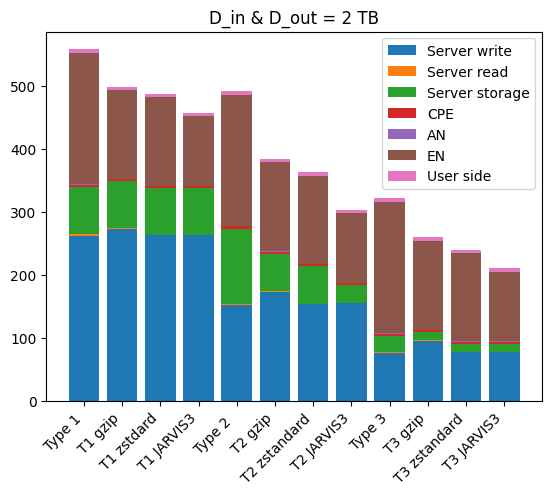

In [51]:
index = 20

server_write = [
    data1[index][0],
    data4[index][0],
    data7[index][0],
    data10[index][0],
    data2[index][0],
    data5[index][0],
    data8[index][0],
    data11[index][0],
    data3[index][0],
    data6[index][0],
    data9[index][0],
    data12[index][0],
]


cpe = [
    data1[index][1] + data1[index][7],
    data4[index][1] + data4[index][7],
    data7[index][1] + data7[index][7],
    data10[index][1] + data10[index][7],
    data2[index][1] + data2[index][7],
    data5[index][1] + data5[index][7],
    data8[index][1] + data8[index][7],
    data11[index][1] + data11[index][7],
    data3[index][1] + data3[index][7],
    data6[index][1] + data6[index][7],
    data9[index][1] + data9[index][7],
    data12[index][1] + data12[index][7],
]
an = [
    data1[index][2] + data1[index][8],
    data4[index][2] + data4[index][8],
    data7[index][2] + data7[index][8],
    data10[index][2] + data10[index][8],
    data2[index][2] + data2[index][8],
    data5[index][2] + data5[index][8],
    data8[index][2] + data8[index][8],
    data11[index][2] + data11[index][8],
    data3[index][2] + data3[index][8],
    data6[index][2] + data6[index][8],
    data9[index][2] + data9[index][8],
    data12[index][2] + data12[index][8],
]
en = [
    data1[index][3] + data1[index][9],
    data4[index][3] + data4[index][9],
    data7[index][3] + data7[index][9],
    data10[index][3] + data10[index][9],
    data2[index][3] + data2[index][9],
    data5[index][3] + data5[index][9],
    data8[index][3] + data8[index][9],
    data11[index][3] + data11[index][9],
    data3[index][3] + data3[index][9],
    data6[index][3] + data6[index][9],
    data9[index][3] + data9[index][9],
    data12[index][3] + data12[index][9],
]
userside = [
    data1[index][4] + data1[index][10],
    data4[index][4] + data4[index][10],
    data7[index][4] + data7[index][10],
    data10[index][4] + data10[index][10],
    data2[index][4] + data2[index][10],
    data5[index][4] + data5[index][10],
    data8[index][4] + data8[index][10],
    data11[index][4] + data11[index][10],
    data3[index][4] + data3[index][10],
    data6[index][4] + data6[index][10],
    data9[index][4] + data9[index][10],
    data12[index][4] + data12[index][10],
]
server_storage = [
    data1[index][5],
    data4[index][5],
    data7[index][5],
    data10[index][5],
    data2[index][5],
    data5[index][5],
    data8[index][5],
    data11[index][5],
    data3[index][5],
    data6[index][5],
    data9[index][5],
    data12[index][5],
]
server_read = [
    data1[index][6],
    data4[index][6],
    data7[index][6],
    data10[index][6],
    data2[index][6],
    data5[index][6],
    data8[index][6],
    data11[index][6],
    data3[index][6],
    data6[index][6],
    data9[index][6],
    data12[index][6],
]

d_in = [i for i in range(0, max_size, step)]
x = [
    "Type 1", 
    "T1 gzip", 
    "T1 zstdard", 
    "T1 JARVIS3", 
    "Type 2 ", 
    "T2 gzip", 
    "T2 zstandard", 
    "T2 JARVIS3", 
    "Type 3", 
    "T3 gzip", 
    "T3 zstandard", 
    "T3 JARVIS3"
]
fig, ax = plt.subplots()
ax.bar(x, server_write)
ax.bar(x, server_read, bottom=server_write)
ax.bar(x, server_storage, bottom=[sum(x) for x in zip(server_write, server_read)])
ax.bar(x, cpe, bottom=[sum(x) for x in zip(server_write, server_read, server_storage)])
ax.bar(x, an, bottom=[sum(x) for x in zip(server_write, server_read, server_storage, cpe)])
ax.bar(x, en, bottom=[sum(x) for x in zip(server_write, server_read, server_storage, cpe, an)])
ax.bar(x, userside, bottom=[sum(x) for x in zip(server_write, server_read, server_storage, cpe, an, en)])

ax.legend(["Server write", "Server read", "Server storage", "CPE", "AN", "EN", "User side"])
ax.set_title(f"D_in & D_out = 2 TB")
plt.xticks(rotation=45, ha="right")
